In [1]:
import os
import dill, sys
import copy
import numpy as np
import matplotlib.pyplot as plt

import kuaizi as kz
from kuaizi.display import display_single, SEG_CMAP, display_scarlet_results_tigress

from astropy.io import fits
import astropy.wcs as wcs
import astropy.units as u
from astropy.table import Table, Column, Row, vstack, hstack
from astropy.coordinates import SkyCoord


import pickle

In [2]:
from astropy.visualization import lupton_rgb

In [20]:
env_dict = {'project': 'HSC', 'name': 'LSBG', 'data_dir': '/scratch/gpfs/jiaxuanl/Data'}
kz.utils.set_env(**env_dict)
kz.set_matplotlib(style='JL', usetex=True, dpi=100, fontsize=15)

### Get HSC images

In [4]:
from unagi import config
from unagi import hsc
from unagi.task import hsc_cutout

pdr2 = hsc.Hsc(dr='pdr2', rerun='pdr2_wide')

# Get table list from /home/jiaxuanl/.local/lib/python3.10/site-packages/unagi-0.1.3.dev19-py3.10.egg/unagi/data/pdr2_wide/pdr2_wide_tables.fits


1) Target (galaxy): 02:37:55.48 -06:15:23.86 (PA=0)

2) Sky (offset field): 02:37:52.974 -06:14:55.322 (PA=0)

In [6]:
from astropy import units as u

In [9]:
coord = SkyCoord('02:37:55.48 -06:15:23.86', unit=(u.hourangle, u.deg))

# Angular size
s_ang = 3 * u.arcmin

# Filters
filters = 'griz'

for filt in filters:
    cutout_test = hsc_cutout(coord, cutout_size=s_ang, filters=filt, 
                             archive=pdr2, use_saved=False, output_dir='./Cutout/magellan_proposal/', 
                             verbose=True, prefix='LSBG-285',
                             save_output=True, image=True, mask=False, variance=False)

# Retrieving cutout image in filter: g
# Retrieving cutout image in filter: r
# Retrieving cutout image in filter: i
# Retrieving cutout image in filter: z


In [10]:
from kuaizi.utils import img_cutout

## Finder charts

In [11]:
obj_coord = SkyCoord('02:37:55.48 -06:15:23.86', unit=(u.hourangle, u.deg))
sky_coord = SkyCoord('02:37:52.974 -06:14:55.322', unit=(u.hourangle, u.deg))

In [14]:
dra, ddec = obj_coord.spherical_offsets_to(sky_coord)
print(dra.to(u.arcsec), ddec.to(u.arcsec))

-37.3667arcsec 28.5376arcsec


In [24]:
from matplotlib import patches

Offset from galaxy to sky: -37.3667arcsec 28.5376arcsec


Text(0.5, 1.0, 'LSBG-285, Sept 22 2022, IFUM (PI: S. Danieli)')

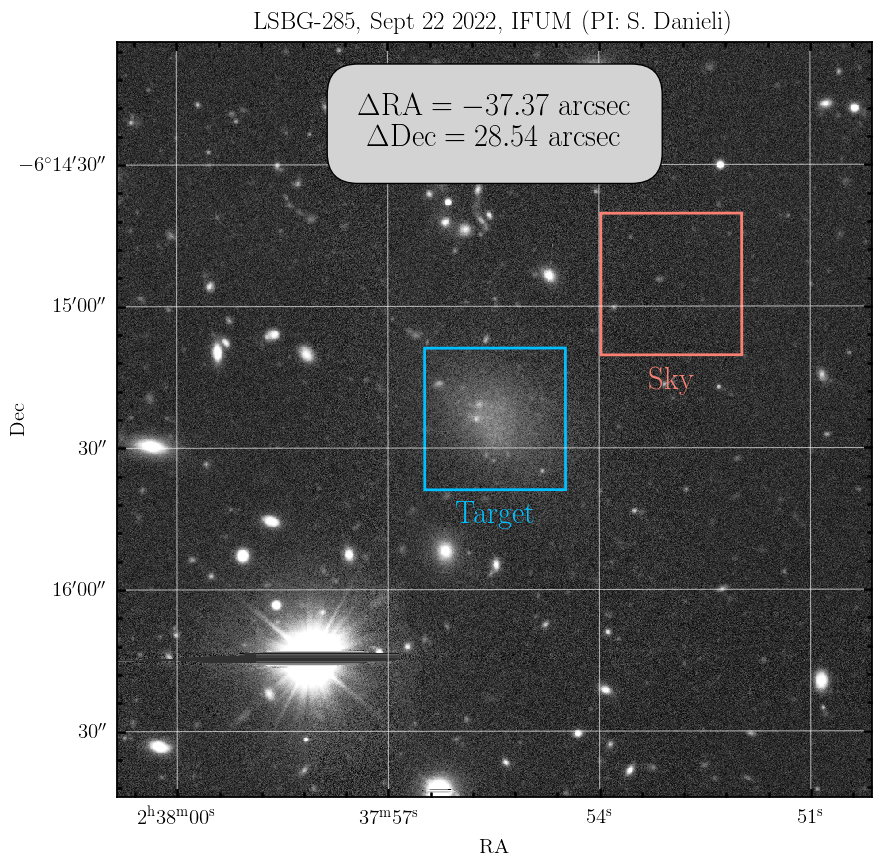

In [68]:
size = 160
griz = []

for filt in list('griz'):
    hdu = fits.open(f'./Cutout/magellan_proposal/LSBG-285_{filt}.fits')
    w = wcs.WCS(hdu[1].header)
    temp = img_cutout(hdu[1].data, w, 
               obj_coord.ra, obj_coord.dec, 
                      size=(size, size), pixel_unit=False, pixel_scale=0.168)
    griz.append(temp[0].data)
    hdu.close()

f = plt.figure(figsize=(10, 10))
w = wcs.WCS(temp[2])
ax = plt.subplot(projection=w)
try:
    ax = display_single(griz[2], cmap='Greys_r', ax=ax, contrast=0.1)
except:
    pass

### Calculate offset from galaxy to sky
dra, ddec = obj_coord.spherical_offsets_to(sky_coord)
print('Offset from galaxy to sky:', dra.to(u.arcsec), ddec.to(u.arcsec))

ax.text(obj_coord.ra.value, 
        obj_coord.dec.value + 0.016, 
        r'$\Delta\mathrm{RA}=' + f'{dra.to(u.arcsec).value:.2f}' + r'\ \rm{arcsec}$' + '\n' + r'$\Delta\mathrm{Dec}=' + f'{ddec.to(u.arcsec).value:.2f}' + r'\ \rm{arcsec}$', 
        ha='center', color='k', fontweight='bold',
        transform=ax.get_transform('fk5'), fontsize=22,
        bbox=dict(facecolor='lightgray', edgecolor='black', boxstyle='round,pad=1'))


# Add FoV
fov = 30 * u.arcsec
rect = patches.Rectangle(((sky_coord.ra - fov/2).value, 
                          (sky_coord.dec - fov/2).value),
                         fov.to(u.deg).value, fov.to(u.deg).value,
                         linewidth=2, 
                         edgecolor='salmon', facecolor='none',
                         transform=ax.get_transform('fk5'))
ax.add_patch(rect)
ax.text((sky_coord.ra).value, 
        (sky_coord.dec - fov / (1.7)).value, 
        'Sky',
        ha='center', va='top', color='salmon', fontweight='bold',
        transform=ax.get_transform('fk5'), fontsize=22,)


fov = 30 * u.arcsec
rect = patches.Rectangle(((obj_coord.ra - fov/2).value, 
                          (obj_coord.dec - fov/2).value),
                         fov.to(u.deg).value, fov.to(u.deg).value,
                         linewidth=2, 
                         edgecolor='deepskyblue', facecolor='none',
                         transform=ax.get_transform('fk5'))
ax.add_patch(rect)
ax.text((obj_coord.ra).value, 
        (obj_coord.dec - fov / (1.7)).value, 
        'Target',
        ha='center', va='top', color='deepskyblue', fontweight='bold',
        transform=ax.get_transform('fk5'), fontsize=22,)

plt.grid(color='white', ls='solid')
plt.xlabel('RA')
plt.ylabel('Dec', labelpad=0)
plt.title('LSBG-285, Sept 22 2022, IFUM (PI: S. Danieli)')